In [1]:
import os 
dir_path = os.getcwd()

In [2]:
import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)
import matplotlib.pyplot as plt

from utils import coeff_determination
# preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import Model

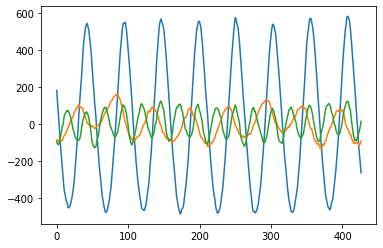

In [3]:
# Loading data
data = np.load('SST_Train.npy').T

plt.figure()
plt.plot(data[:,0])
plt.plot(data[:,1])
plt.plot(data[:,2])
plt.show()

In [11]:
#Build the model which does basic map of inputs to coefficients
class standard_lstm(Model):
    def __init__(self,data):
        super(standard_lstm, self).__init__()
        
        # Set up the data for the LSTM
        self.data_tsteps = np.shape(data)[0]
        self.state_len = np.shape(data)[1]
        
        self.preproc_pipeline = Pipeline([('stdscaler', StandardScaler()),('minmax', MinMaxScaler(feature_range=(-1, 1)))])
        self.data = self.preproc_pipeline.fit_transform(data)
        
        self.seq_num = 1
        self.total_size = np.shape(data)[0]-int(self.seq_num) # Limit of sampling

        input_seq = np.zeros(shape=(self.total_size,self.seq_num,self.state_len))  #[samples,n_inputs,state_len]
        output_seq = np.zeros(shape=(self.total_size,self.state_len)) #[samples,n_outputs,state_len]

        snum = 0
        for t in range(0,self.total_size):
            input_seq[snum,:,:] = self.data[None,t:t+self.seq_num,:]
            output_seq[snum,:] = self.data[None,t+self.seq_num,:]        
            snum = snum + 1        
        
#         # Shuffle dataset
#         idx = np.arange(snum)
#         np.random.shuffle(idx)
#         input_seq = input_seq[idx]
#         output_seq = output_seq[idx]

        # Split into train and test
        self.input_seq_test = input_seq[int(0.9*snum):]
        self.output_seq_test = output_seq[int(0.9*snum):]
        input_seq = input_seq[:int(0.9*snum)]
        output_seq = output_seq[:int(0.9*snum)]

        # Split into train and valid
        self.ntrain = int(0.8*np.shape(input_seq)[0])
        self.nvalid = np.shape(input_seq)[0] - self.ntrain

        self.input_seq_train = input_seq[:self.ntrain]
        self.output_seq_train = output_seq[:self.ntrain]

        self.input_seq_valid = input_seq[self.ntrain:]
        self.output_seq_valid = output_seq[self.ntrain:]        
        
        self.num_neurons = 20
        self.lstm_1 = tf.keras.layers.LSTMCell(self.num_neurons)
        self.lstm_2 = tf.keras.layers.LSTMCell(self.num_neurons)
        self.out_layer = tf.keras.layers.Dense(self.state_len)
        
        self.train_op = tf.keras.optimizers.Adam(learning_rate=0.001)
        
    # Running the model
    def call(self,X):
        
        X = tf.unstack(X,axis=0)
        
        c1_states = []
        c2_states = []
        outs = []
        for cur_inputs in X:
            
            h_c1 = [tf.zeros((1,self.num_neurons)),  tf.zeros((1,self.num_neurons))]  # must initialize hidden/cell state for lstm cell
            self.h_c1 = tf.convert_to_tensor(h_c1, dtype='float32')
            h_c2 = [tf.zeros((1,self.num_neurons)),  tf.zeros((1,self.num_neurons))]  # must initialize hidden/cell state for lstm cell
            self.h_c2 = tf.convert_to_tensor(h_c2, dtype='float32')
            
            c1_temp = []
            c2_temp = []
            input_temp = tf.unstack(cur_inputs,axis=0)
            
            for timestep in input_temp:
                out, self.h_c1 = self.lstm_1(tf.expand_dims(timestep, axis=0), self.h_c1)
                out, self.h_c2 = self.lstm_2(out, self.h_c2)
                      
                h1, c1 = self.h_c1
                h2, c2 = self.h_c2
                                             
                c1_temp.append(c1)
                c2_temp.append(c2)
            
            outs.append(out)
            c1_states.append(c1_temp)
            c2_states.append(c2_temp)
            
            
        outs = tf.convert_to_tensor(outs, dtype='float32')
        out = self.out_layer(outs)

        return out, [c1_states,c2_states]
    
        # Regular MSE
    def get_loss(self,X,Y):
        
        op, c_states = self.call(X)
        
        return tf.reduce_mean(tf.math.square(op-Y))
    
    def get_grad(self,X,Y):
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            L = self.get_loss(X,Y)
            g = tape.gradient(L, self.trainable_variables)
        return g
    
    # perform gradient descent - regular
    def network_learn(self,X,Y):
        g = self.get_grad(X,Y)
        self.train_op.apply_gradients(zip(g, self.trainable_variables))

    # Train the model
    def train_model(self):
        plot_iter = 0
        stop_iter = 0
        patience = 100
        best_valid_loss = 999999.0 # Some large number 

        self.num_batches = 20
        self.train_batch_size = int(self.ntrain/self.num_batches)
        self.valid_batch_size = int(self.nvalid/self.num_batches)
        
        for i in range(100):
            # Training loss
            print('Training iteration:',i)
            
            for batch in range(self.num_batches):
                input_batch = self.input_seq_train[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                output_batch = self.output_seq_train[batch*self.train_batch_size:(batch+1)*self.train_batch_size]
                self.network_learn(input_batch,output_batch)

            # Validation loss
            valid_loss = 0.0
            valid_r2 = 0.0

            for batch in range(self.num_batches):
                input_batch = self.input_seq_valid[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]
                output_batch = self.output_seq_valid[batch*self.valid_batch_size:(batch+1)*self.valid_batch_size]

                valid_loss = valid_loss + self.get_loss(input_batch,output_batch).numpy()
                predictions = self.call(self.input_seq_valid)[0]
                
                valid_r2 = valid_r2 + coeff_determination(predictions,self.output_seq_valid)

            valid_r2 = valid_r2/(batch+1)


            # Check early stopping criteria
            if valid_loss < best_valid_loss:
                
                print('Improved validation loss from:',best_valid_loss,' to:', valid_loss)
                print('Validation R2:',valid_r2)
            
                best_valid_loss = valid_loss
                self.save_weights('./checkpoints/my_checkpoint')
                
                stop_iter = 0
            else:
                print('Validation loss (no improvement):',valid_loss)
                print('Validation R2:',valid_r2)
                stop_iter = stop_iter + 1

            if stop_iter == patience:
                break


    # Load weights
    def restore_model(self):
        self.load_weights(dir_path+'/checkpoints/my_checkpoint') # Load pretrained model

    # Do some testing
    def model_inference(self,test_data):
        # Restore from checkpoint
        self.restore_model()

        # Scale testing data
        test_data = self.preproc_pipeline.fit_transform(test_data)

        # Test sizes
        test_total_size = np.shape(test_data)[0]-int(self.seq_num) # Limit of sampling

        # Input placeholder setup
        rec_input_seq = test_data[:self.seq_num,:].reshape(1,self.seq_num,self.state_len)
        
        # True outputs
        rec_output_seq = np.zeros(shape=(test_total_size,self.state_len)) #[samples,n_outputs,state_len]
        snum = 0
        for t in range(test_total_size):
            rec_output_seq[snum,:] = test_data[None,t+self.seq_num,:]        
            snum = snum + 1

        # Recursive predict
        rec_pred = np.copy(rec_output_seq)
        state_history = []
        for t in range(test_total_size):
            preds = self.call(rec_input_seq)
            rec_pred[t] = preds[0].numpy()
            state_history.append(preds[1])
            rec_input_seq[0,0:-1,:] = rec_input_seq[0,1:]
            rec_input_seq[0,-1,:] = rec_pred[t]
            
        
        # Rescale
        rec_pred = self.preproc_pipeline.inverse_transform(rec_pred)
        rec_output_seq = self.preproc_pipeline.inverse_transform(rec_output_seq)

        # plot
        for i in range(self.state_len):
            plt.figure()
            plt.title('Mode '+str(i))
            plt.plot(rec_pred[:,i],label='Predicted')
            plt.plot(rec_output_seq[:,i],label='True')
            plt.legend()
            plt.show()

        return rec_output_seq, rec_pred, state_history

In [12]:
# Initialize model
lstm_model = standard_lstm(data)

In [8]:
lstm_model.train_model() # Train and exit

Training iteration: 0
Improved validation loss from: 999999.0  to: 6.16938604414463
Validation R2: 0.01099938574589543
Training iteration: 1
Improved validation loss from: 6.16938604414463  to: 6.122032254934311
Validation R2: 0.01978959558122917
Training iteration: 2
Improved validation loss from: 6.122032254934311  to: 6.0683213621377945
Validation R2: 0.02985416715795286
Training iteration: 3
Improved validation loss from: 6.0683213621377945  to: 6.000846818089485
Validation R2: 0.04242697007022833
Training iteration: 4
Improved validation loss from: 6.000846818089485  to: 5.913740321993828
Validation R2: 0.0585376049466283
Training iteration: 5
Improved validation loss from: 5.913740321993828  to: 5.801804214715958
Validation R2: 0.0791265191987894
Training iteration: 6
Improved validation loss from: 5.801804214715958  to: 5.661014810204506
Validation R2: 0.10494236192969757
Training iteration: 7
Improved validation loss from: 5.661014810204506  to: 5.489761829376221
Validation R2:

Improved validation loss from: 1.5161554915830493  to: 1.504595272243023
Validation R2: 0.7741826469272635
Training iteration: 64
Improved validation loss from: 1.504595272243023  to: 1.493605261668563
Validation R2: 0.7757048124388164
Training iteration: 65
Improved validation loss from: 1.493605261668563  to: 1.4831653889268637
Validation R2: 0.7771457778034278
Training iteration: 66
Improved validation loss from: 1.4831653889268637  to: 1.4732546331360936
Validation R2: 0.7785085158333496
Training iteration: 67
Improved validation loss from: 1.4732546331360936  to: 1.4638530677184463
Validation R2: 0.7797959023767391
Training iteration: 68
Improved validation loss from: 1.4638530677184463  to: 1.4549401756376028
Validation R2: 0.7810109000638172
Training iteration: 69
Improved validation loss from: 1.4549401756376028  to: 1.4464960107579827
Validation R2: 0.782156392651524
Training iteration: 70
Improved validation loss from: 1.4464960107579827  to: 1.438500483520329
Validation R2: 

In [13]:
lstm_model.restore_model()

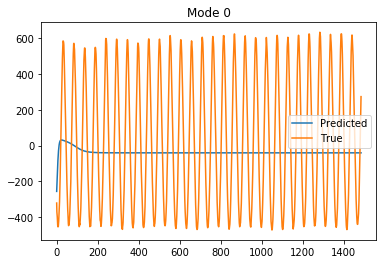

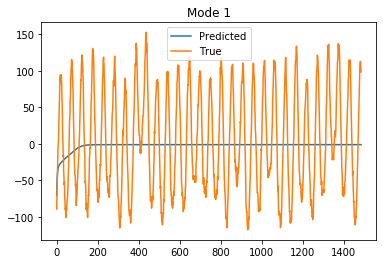

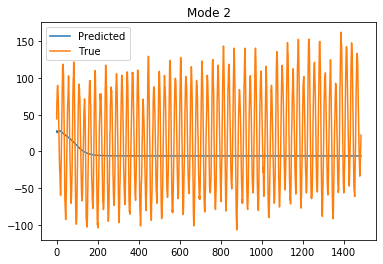

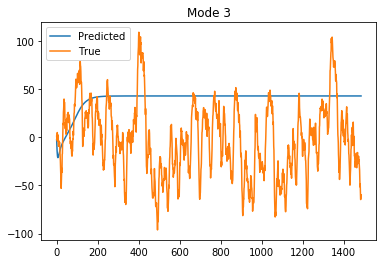

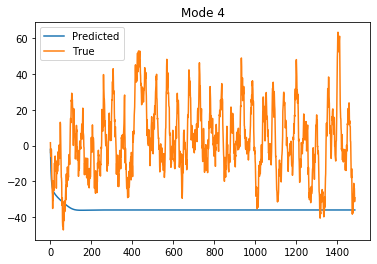

In [14]:
data = np.load('SST_Test.npy').T
true, predicted, states = lstm_model.model_inference(data) # Do some inference

In [33]:
state_list_0 = []
state_list_1 = []
for state in states:
    state_list_0.append(state[0][0][0].numpy())
    state_list_1.append(state[1][0][0].numpy())
    
states_0 = np.asarray(state_list_0)
states_1 = np.asarray(state_list_1)

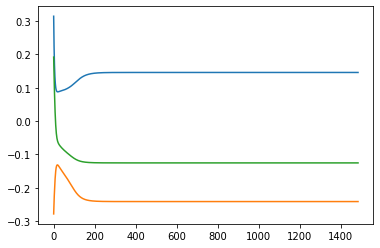

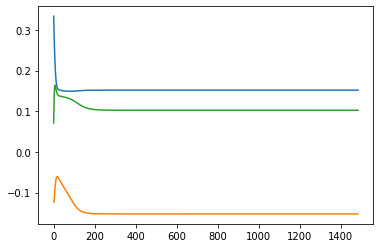

In [38]:
plt.figure()
plt.plot(states_0[:,0,0])
plt.plot(states_0[:,0,1])
plt.plot(states_0[:,0,2])
plt.show()

plt.figure()
plt.plot(states_1[:,0,0])
plt.plot(states_1[:,0,1])
plt.plot(states_1[:,0,2])
plt.show()